In [2]:
###THIS NOTEBOOK IS ONLY A CONTINUATION OF CLASSICAL STATISTICS METHOD

## OVERVIEW
---
* Feature Engineering
* Data Preprocessing With Boxcox and StandardScaler
* Keras LSTM  Model to Forecasting the Bitcoin Price

In [60]:
#VIZ LIBRARY
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Preprocessing
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


#CLASSICAL STATS
import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from scipy.stats import boxcox

#DEEP LEARNING LIB
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

#METRICS
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error


import warnings 
warnings.filterwarnings('ignore')

In [3]:
#get the data
df = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')

## FEATURE ENGINEERING
---

In [4]:
#convert data to datetime object and get the bitcoin real price
df['date'] = pd.to_datetime(df['Timestamp'], unit='s').dt.date
df = pd.DataFrame(df.groupby('date')['Weighted_Price'].mean())
df = df.reset_index()
df = df.sort_values('date')

In [5]:
#extract the date
df['day'] = pd.to_datetime(df.date).dt.day
df['dayofweek'] = pd.to_datetime(df.date).dt.dayofweek
df['week'] = pd.to_datetime(df.date).dt.week
df['month'] = pd.to_datetime(df.date).dt.month
df['year'] = pd.to_datetime(df.date).dt.year

#lag the price
for i in range(1,8):
    df['lag_'+str(i)] = df.Weighted_Price.shift(i).fillna(0)

#drop the date feature since it was already extracted
df.drop('date', axis=1, inplace=True)

df.columns = ['price', 'day', 'dayofweek', 'week', 'month', 'year', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']

In [6]:
#show new data frame
df.head()

,price,day,dayofweek,week,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,335.000000,1,0,49,12,2014,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,377.854911,2,1,49,12,2014,335.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,377.818333,3,2,49,12,2014,377.854911,335.000000,0.000000,0.0,0.0,0.0,0.0
3,377.100000,4,3,49,12,2014,377.818333,377.854911,335.000000,0.0,0.0,0.0,0.0
4,378.000000,6,5,49,12,2014,377.100000,377.818333,377.854911,335.0,0.0,0.0,0.0


## DATA PREPROCESSING
---

In [7]:
#normalize the feateure except for the price
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df.drop('price', axis=1))
df[['day', 'dayofweek', 'week', 'month', 'year', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']] = scaled_feat

#split tha data
df_train = df[:-30]
df_test = df[-30:]

X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

#### BOXCOX FOR DATA NORMALIZATION

Text(0.5, 1.0, 'TRANSFORMED VALUE OF PRICE')

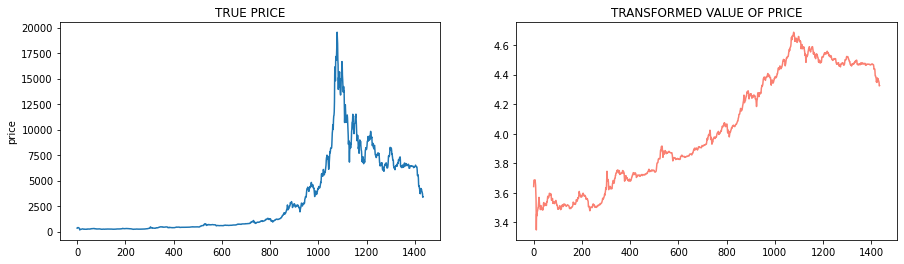

<Figure size 936x288 with 0 Axes>

In [8]:
#use boxcox to normalize and remove the noise of data
bc_values, ld = boxcox(df_train.price)

fig, ax = plt.subplots(1,2, figsize=(15,4))
plt.figure(figsize=(13,4))
sns.lineplot(np.arange(len(df_train.price)), df.price[:-30], ax=ax[0])
sns.lineplot(np.arange(len(df_train.price)), bc_values, ax=ax[1], color='salmon')

ax[0].set_title('TRUE PRICE')
ax[1].set_title('TRANSFORMED VALUE OF PRICE')

In [9]:
#assign boxcox value to df_train price
df_train['price'] = bc_values

In [10]:
#check the new training data
df_train.head()

,price,day,dayofweek,week,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,3.641774,-1.665717,-1.498643,1.46615,1.569967,-2.203809,-0.823943,-0.823060,-0.822183,-0.821315,-0.820441,-0.819569,-0.818717
1,3.684644,-1.552321,-0.997956,1.46615,1.569967,-2.203809,-0.734649,-0.823060,-0.822183,-0.821315,-0.820441,-0.819569,-0.818717
2,3.684610,-1.438926,-0.497269,1.46615,1.569967,-2.203809,-0.723226,-0.733785,-0.822183,-0.821315,-0.820441,-0.819569,-0.818717
3,3.683939,-1.325530,0.003418,1.46615,1.569967,-2.203809,-0.723236,-0.722365,-0.732928,-0.821315,-0.820441,-0.819569,-0.818717
4,3.684779,-1.098738,1.004791,1.46615,1.569967,-2.203809,-0.723427,-0.722374,-0.721510,-0.732080,-0.820441,-0.819569,-0.818717


## LSTM MODEL
---

In [11]:
#split the data
X_train = df_train.drop('price', axis=1)
y_train = df_train.price

#reshaping
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [33]:
#build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

#compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#get summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 50)             12600     
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)               

In [34]:
#fit the training data
model.fit(X_train, y_train,epochs=200, batch_size=4)

Epoch 1/200
1435/1435 [==============================] - 5s 3ms/step - loss: 2.8641
Epoch 2/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.1504
Epoch 3/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.1176
Epoch 4/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.1086
Epoch 5/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0988
Epoch 6/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.1029
Epoch 7/200
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0951
Epoch 8/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0892
Epoch 9/200
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0950
Epoch 10/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0947
Epoch 11/200
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0847A: 0s - los
Epoch 12/200
1435/1435 [==============================] - 3s 2m

1435/1435 [==============================] - 3s 2ms/step - loss: 0.0032
Epoch 98/200
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 99/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 100/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0027
Epoch 101/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 102/200
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0029
Epoch 103/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 104/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 105/200
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0026
Epoch 106/200
1435/1435 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 107/200
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0025
Epoch 108/200
1435/1435 [==============================] - 3s 2ms/step

#### MODEL TRAINING LOSS

Text(0, 0.5, 'Loss')

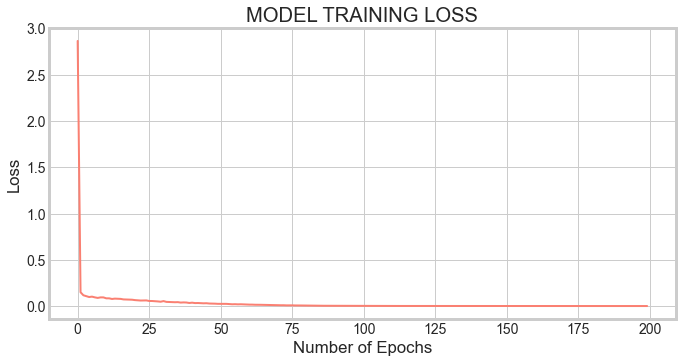

In [59]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['loss'], color='salmon', lw=2)
plt.title('MODEL TRAINING LOSS')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

#### GET PREDICTION

In [35]:
#inverse transform the boxcox value
def invboxcox(y,ld):
     if ld == 0:
        return(np.exp(y))
     else:
        return(np.exp(np.log(ld*y+1)/ld))

In [36]:
#get the prediction
predictions = model.predict(X_test)

In [37]:
#inverse transform the values
predictions =invboxcox(predictions, ld)
predictions = predictions.reshape(predictions.shape[0],)

Text(0, 0.5, 'Price')

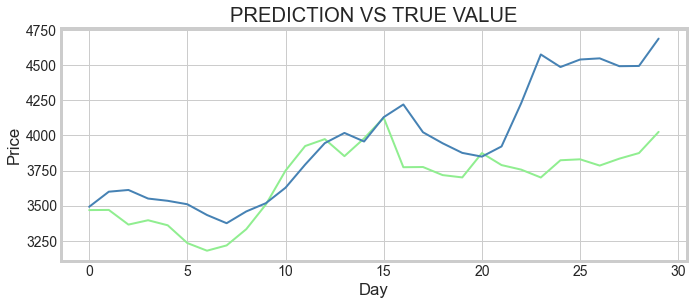

In [50]:
#Show comparison to the true value
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
plt.figure(figsize=(10,4))


sns.lineplot(np.arange(len(y_test)), y=y_test, color='lightgreen', lw=2)
sns.lineplot(np.arange(len(y_test)), y=predictions, color = 'steelblue', lw=2)

plt.title('PREDICTION VS TRUE VALUE')
plt.xlabel('Day')
plt.ylabel('Price')


#### (MAE, MSE, RMSE)

In [73]:
print('MAE: ', round(mean_absolute_error(y_test, predictions),2))
print('MSE: ', round(mean_squared_error(y_test, predictions),2))
print('RMSE: ', round(np.sqrt(mean_squared_error(y_test, predictions)),2))

MAE:  289.98
MSE:  150189.21
RMSE:  387.54


#### R-SQUARED SCORE

In [74]:
print('RSQUARED SCORE: ', r2_score(y_test, predictions))

RSQUARED SCORE:  -1.2968133794571193


### INSIGHTS
---
* LSTM Model Did Pretty Well When Predicting the Trend of Bitcoin.
* the First 20 Days of Prediction Looks Good as Seen on the Plot Above, but the Last 10 Days of Forecast Are Way Too Off.